In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
print(model)

CUDA Available:  True
Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist', 
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=128, shuffle=True)
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epoch_num = 20
for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        # Calculate the error between model predictins and actual labels
        loss = criterion(outputs, labels)
        
        # Initiate backward propagation
        loss.backward()
        
        # Update weights
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[Epoch {epoch + 1}: batch {i + 1}] loss: {running_loss / 200}')
            running_loss = 0.0

print('Finished Training')

data_test = datasets.MNIST('./mnist',
                           train=False,
                           download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                           ]))

test_loader = torch.utils.data.DataLoader(data_test, batch_size=256)
# Prevent training
model.eval()

total_correct = 0
avg_loss = 0.0
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
   
    output = model(inputs)
    avg_loss += criterion(output, labels).sum()
    
    pred = output.detach().max(1)[1]
    total_correct += pred.eq(labels.view_as(pred)).sum()

avg_loss /= len(data_test)
avg_loss = avg_loss.detach().cpu().item()
accuracy = float(total_correct) / len(data_test)
print(f'Test Avg. Loss: {avg_loss}, Accuracy: {accuracy}')


# Save model state for re-use
my_awesome_model = 'my-lenet.pth'
torch.save(model.state_dict(), my_awesome_model)

0it [00:00, ?it/s]

9920512it [00:02, 3370805.12it/s]                            


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 48383.78it/s]                           
0it [00:00, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


1654784it [00:02, 816298.04it/s]                             
0it [00:00, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


8192it [00:00, 18444.21it/s]            


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!
[Epoch 1: batch 200] loss: 2.3010472464561462
[Epoch 1: batch 400] loss: 2.280189059972763
[Epoch 2: batch 200] loss: 2.145663197040558
[Epoch 2: batch 400] loss: 1.6888514465093614
[Epoch 3: batch 200] loss: 1.0690205848217011
[Epoch 3: batch 400] loss: 0.8744930478930474
[Epoch 4: batch 200] loss: 0.7610926553606987
[Epoch 4: batch 400] loss: 0.7002011394500732
[Epoch 5: batch 200] loss: 0.640644628405571
[Epoch 5: batch 400] loss: 0.5988157786428928
[Epoch 6: batch 200] loss: 0.5644095429778099
[Epoch 6: batch 400] loss: 0.5403728663921357
[Epoch 7: batch 200] loss: 0.5193464128673076
[Epoch 7: batch 400] loss: 0.4988238672912121
[Epoch 8: batch 200] loss: 0.47751245737075804
[Epoch 8: batch 400] loss: 0.47299677863717077
[Epoch 9: batch 200] loss: 0.4544230782985687
[Epoch 9: batch 400] loss: 0.4370796625316143
[Epoch 10: batch 200] loss: 0.4303811772167683
[Epoch 10: batch 400] loss: 0.

In [0]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    
    perturbed_image = image + epsilon * sign_data_grad
    
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist',
                   train=False,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=1, shuffle=True)

In [0]:
#For each class select 10 images not from this class.
#Perform attack to move selected images to this class.
# for each class select image with highest confidence.

#Best sample is the one with higher confidence.

def select_images_for_attack(model, device, test_loader):
    selected_images = list([] for i in range(10))
    perturbed_images = list([] for i in range(10))
    count = 0
    adversarial_success = list(0 for i in range(10))
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() != target.item():
            continue
        for i in range(10):
            if init_pred.item() != i and len(selected_images[i]) < 10:     
                selected_images[i].append(data)
                count += 1
                break
        if count==100: # if already have 100 images 
            break
    return selected_images

def perform_attack(images, model, epsilon=0.05, max_iter=10):
    adversarial_success = [0. for i in range(10)]
    highest_confidence_images = []
    for i in range(10):
        current_images = images[i]
        adv_target = torch.tensor([i])
        adv_target = adv_target.to(device)
        max_confidence = 0.0
        for img in current_images:
            for j in range(max_iter):
                img.requires_grad = True
                output = model(img)
                true_label = output.detach().max(1, keepdim=True)[1]
                loss = F.nll_loss(output, adv_target)
                model.zero_grad()
                loss.backward()
                img_grad = img.grad.data
                perturbed_image = fgsm_attack(img, epsilon, -img_grad)
                output = model(perturbed_image)
                probability = F.softmax(output)[0][i].item()
                if probability > max_confidence:
                    max_confidence = probability
                    best_adv_img = perturbed_image.squeeze().detach().cpu().numpy()
                    best_adv_img_real_label = true_label
                final_pred = output.max(1, keepdim=True)[1]
                if final_pred.item() == i:
                    adversarial_success[i] += 1
                    break
                else:
                    img = perturbed_image.detach()
        highest_confidence_images.append((best_adv_img, max_confidence, i, best_adv_img_real_label))
    return highest_confidence_images, adversarial_success


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Successful attacks for 0 : 0.0
Successful attacks for 1 : 0.0
Successful attacks for 2 : 0.0
Successful attacks for 3 : 1.0
Successful attacks for 4 : 0.0
Successful attacks for 5 : 1.0
Successful attacks for 6 : 1.0
Successful attacks for 7 : 0.0
Successful attacks for 8 : 0.0
Successful attacks for 9 : 1.0


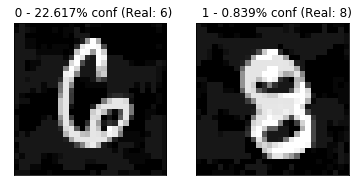

In [8]:
selected_ims = select_images_for_attack(model, device, test_loader)
highest_confidence_images, adversarial_success = perform_attack(selected_ims, model, epsilon=0.03, max_iter=3)

def img_show(imgs, start):
    cnt = start
    for i in range(2):
        cnt += 1
        plt.subplot(1, 2, i+1)
        plt.xticks([  ],  [  ] )
        plt.yticks([  ], [ ])
        img, conf, adv_label, real_label = imgs[cnt-1]
        plt.title(" %2d - %.3f%% conf (Real:%2d)"%(adv_label, conf*100, real_label))
        plt.imshow(img, cmap="gray")

for j in range(10):
    print("Successful attacks for {} : {}".format(j, adversarial_success[j]))

img_show(highest_confidence_images, 0)

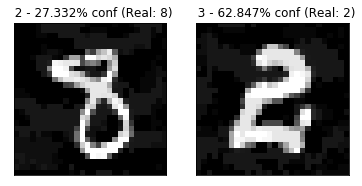

In [9]:
img_show(highest_confidence_images, 2)

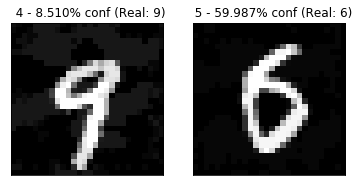

In [10]:
img_show(highest_confidence_images, 4)

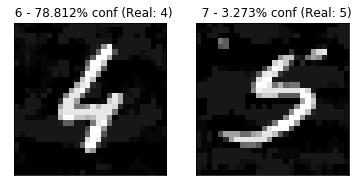

In [11]:
img_show(highest_confidence_images, 6)

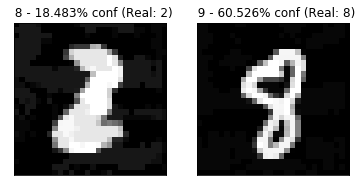

In [12]:
img_show(highest_confidence_images, 8)

In [0]:
# Different epsilons for class "the_class"

def count_iterations(the_class, model, device, test_loader, epsilon=0.01):
    max_iter = 10
    adv_target = torch.tensor([the_class])
    adv_target = adv_target.to(device)
    iterations = []
    #cnt=0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() != target.item():
            continue
        if init_pred.item() != the_class:
            iter = 0
            #cnt += 1
            while iter <= max_iter:
                iter += 1
                data.requires_grad = True
                output = model(data)
                loss = F.nll_loss(output, adv_target)
                model.zero_grad()
                loss.backward()
                data_grad = data.grad.data
                perturbed_image = fgsm_attack(data, epsilon, -data_grad)
                output = model(perturbed_image)
                final_pred = output.max(1, keepdim=True)[1]
                if final_pred == the_class:
                    iterations.append(iter)
                    break
                else:
                    data = perturbed_image.detach()
        #if cnt==1000:
            #break
    all_iter = 0
    for j in range(len(iterations)):
        all_iter += iterations[j]
    avg_iter = all_iter/len(iterations)
    return avg_iter




In [14]:
epsilon = 0.05
while epsilon <= 0.3:
    num_iter = count_iterations(1, model, device, test_loader, epsilon)
    print("Epsilon = %.4f  Iterations: %.4f"%(epsilon, num_iter))
    epsilon += 0.05

Epsilon = 0.0500  Iterations: 6.4075
Epsilon = 0.1000  Iterations: 4.0593
Epsilon = 0.1500  Iterations: 3.4718
Epsilon = 0.2000  Iterations: 3.2765
Epsilon = 0.2500  Iterations: 3.2247
Epsilon = 0.3000  Iterations: 3.3057
